In [14]:
import sys
sys.path.append(sys.path[0]+"\\\\..")  # assuming the first element of sys.path is the path to the notebooks folder, this allows imports from within double-pendulum

import numpy as np
from utils.dataset import Pendulum_Data
import torch
import torch.nn as nn
from torchdiffeq import odeint
from torch.utils.data.dataloader import DataLoader
from models.models import ODEFunc
from models.models import FeedForward
from models.models import PINNLoss
import argparse
from tqdm import tqdm
from matplotlib import pyplot as plt


In [18]:
train_losses = torch.Tensor(torch.load("../models/NODE_119999_train_losses.pt")).numpy()
val_losses = torch.Tensor(torch.load("../models/NODE_119999_val_losses.pt")).numpy()
ges = torch.Tensor(torch.load("../models/NODE_119999_ges.pt")).numpy()
oses = torch.Tensor(torch.load("../models/NODE_119999_oses.pt")).numpy()
tes = torch.Tensor(torch.load("../models/NODE_119999_tes.pt")).numpy()
ttds = torch.Tensor(torch.load("../models/NODE_119999_ttds.pt")).numpy()

C:\Users\BYU Rental\AppData\Local\Temp\ipykernel_4992\3404403251.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_losses = torch.Tensor(torch.load("../models/NODE_1

In [20]:
print(train_losses.shape)
print(val_losses.shape)
print(ges.shape)
print(oses.shape)
print(tes.shape)
print(ttds.shape)

(120000,)
(480,)
(1000, 999)
(1000, 1000)
(1000, 1000)
(1000,)


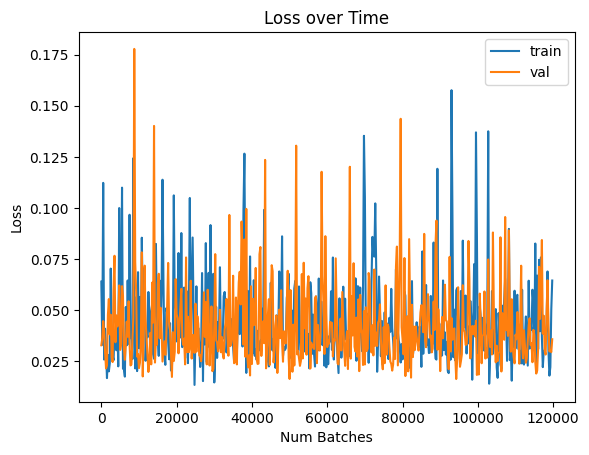

In [22]:
averaged_train_loss = train_losses.reshape((-1, 250)).mean(axis=1)
plt.plot(np.arange(0, 120000, 250), averaged_train_loss, label="train")
plt.plot(np.arange(0, 120000, 250), val_losses, label="val")
plt.title("Loss over Time")
plt.xlabel("Num Batches")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [27]:
print(min(ttds), max(ttds))

0.0 0.0


In [48]:

# Set model and dataloader
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_last = ODEFunc()
model_last = model_last.to(device=device)
model_last.load_state_dict(torch.load("../models/NODE_119999.pt", weights_only=True))
model_last.eval()

model_first = ODEFunc()
model_first = model_first.to(device=device)
model_first.load_state_dict(torch.load("../models/NODE_9999.pt", weights_only=True))
model_first.eval()

data = Pendulum_Data(2000, 2000, size=1)
dl = DataLoader(data, batch_size=1, shuffle=False)


# evaluate
for X_batch, y_batch in dl:
    X_batch, y_batch = X_batch.to(torch.float), y_batch.to(torch.float)

    # get prediction
    y_pred_last = odeint(model_last, X_batch[:, :, 4:], data.delta_t * torch.arange(len(X_batch) + 1))[1:, :, :, :-1]
    y_pred_first = odeint(model_first, X_batch[:, :, 4:], data.delta_t * torch.arange(len(X_batch) + 1))[1:, :, :, :-1]
    y_batch = y_batch[:, :, 4:-1]  # remove mass/length/time information from outputs

    y_pred_last = y_pred_last.cpu().detach().numpy().squeeze()
    y_pred_first = y_pred_first.cpu().detach().numpy().squeeze()
    y_batch = y_batch.cpu().detach().numpy().squeeze()

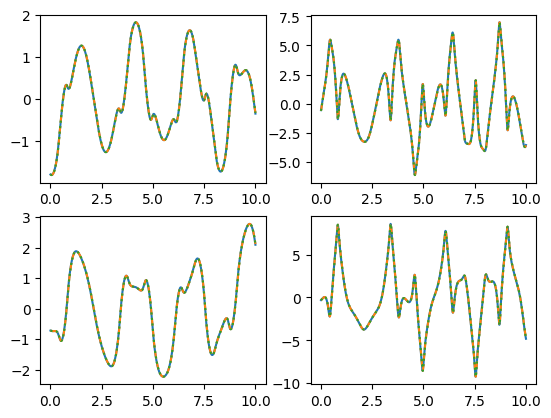

In [58]:
for i in range(4):
    plt.subplot(221 + i)
    plt.plot(np.arange(0, 10.0025, data.delta_t), y_batch[:, i])
    plt.plot(np.arange(0, 10.0025, data.delta_t), y_pred_first[:, i], linestyle="--")
    plt.plot(np.arange(0, 10.0025, data.delta_t), y_pred_last[:, i], linestyle=":")
    
plt.show()

In [31]:
plt.show()